In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import ffmpeg

In [2]:
N_HIDDEN = 4
WIDTH = 128

# 4K
# RESOLUTION_X = 3840
# RESOLUTION_Y = 2160

# 1080p
RESOLUTION_X = 1920
RESOLUTION_Y = 1080

In [3]:
def getLayer(in_dims, out_dims):
    layer = torch.nn.Conv2d(in_dims, out_dims, 3)
    torch.nn.init.uniform_(layer.weight, -1.0, 1.0)
    return layer

In [4]:
def getModel():
    layers = [
        getLayer(2, WIDTH),
        torch.nn.Tanh()
    ]

    for i in range(N_HIDDEN):
        layers.append(getLayer(WIDTH, WIDTH))
        layers.append(torch.nn.Tanh())

    layers.append(getLayer(WIDTH, 3))
    layers.append(torch.nn.Sigmoid())

    model = torch.nn.Sequential(*layers)

    model = model.to(device)
    
    return model

In [5]:
device = torch.device('cuda')

model = getModel()

coords_x = np.linspace(start=-1, stop=1, num=RESOLUTION_X, dtype=np.float32)
coords_y = np.linspace(start=-1, stop=1, num=RESOLUTION_Y, dtype=np.float32)

coords = np.stack(np.meshgrid(coords_x, coords_y))
coords = np.transpose(coords, [1, 2, 0])
coords = torch.tensor(coords).to(device, torch.float).permute([2, 0, 1]).unsqueeze(0)

# coords_flat = coords.reshape(-1, 2)
# coords_flat = torch.tensor(coords_flat).to(torch.float)
# coords_flat = coords_flat.to(device)

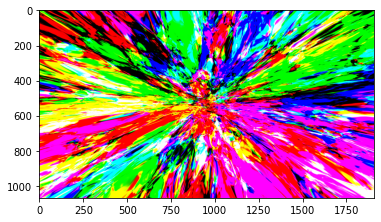

In [6]:
def get_img():
    return model(coords)[0]
#     out = model(coords.permute([2, 0, 1]).unsqueeze(0))[0]
#     return out.permute([1, 2, 0])
# #     out = out_flat.reshape(RESOLUTION_Y, RESOLUTION_X, 3)
# #     return out

def to_viewable(tensor):
    return tensor.to('cpu').permute([1, 2, 0]).numpy()

with torch.no_grad():
    plt.imshow(to_viewable(get_img()))

In [7]:
style_model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg19', pretrained=True)
style_model = style_model.to('cuda').eval()
style_func = layers = list(style_model.children())[0][:6]

Using cache found in /home/aidan/.cache/torch/hub/pytorch_vision_v0.6.0


In [8]:
style_func

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

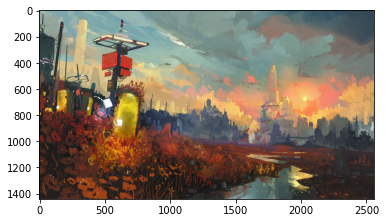

In [9]:
img = np.array(Image.open('/home/aidan/media/images/wallpapers/scrapyard.png')).astype(np.float32)
img -= img.min()
img /= img.max()
img = img[:, :, :3]
img_tensor = torch.tensor(img).to(device)

plt.imshow(img)

In [10]:
get_img().shape

torch.Size([3, 1068, 1908])

In [11]:
def get_gram_matrix(inp):
    features = style_func(inp.unsqueeze(0))[0]
    dims = features.size(0)
    features = features.reshape(dims, -1) # dims, pixels
    gram = torch.matmul(features, features.T)
    return gram

In [12]:
with torch.no_grad():
    style_inp = torch.tensor(img).to(device).permute([2, 0, 1])
    style_gram = get_gram_matrix(style_inp)

0


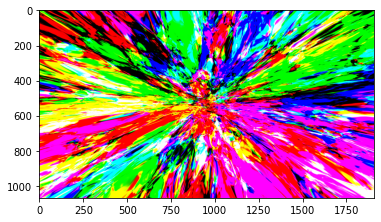

10
20
30
40
50


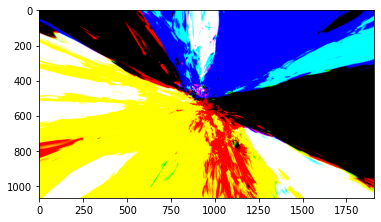

60
70
80
90
100


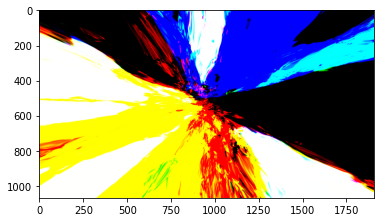

110
120
130
140
150


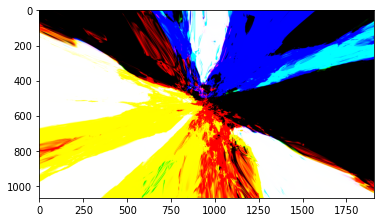

160
170
180
190
200


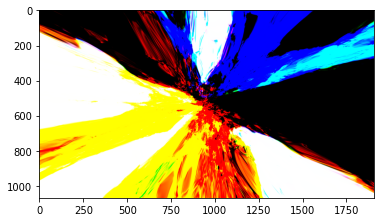

210
220
230
240
250


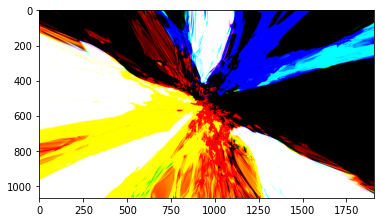

260
270
280
290


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

images = []
for step in range(300):
    if not step % 10:
        print(step)
        
    produced = get_img()
#     loss = torch.nn.functional.mse_loss(img_tensor, produced)
    gram = get_gram_matrix(produced)
    loss = torch.nn.functional.mse_loss(gram, style_gram)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
#     images.append(produced.detach().to('cpu').numpy())
    
    if not step % 50:
        plt.imshow(to_viewable(produced.detach()))
        plt.show()

(-0.5, 1907.5, 1067.5, -0.5)

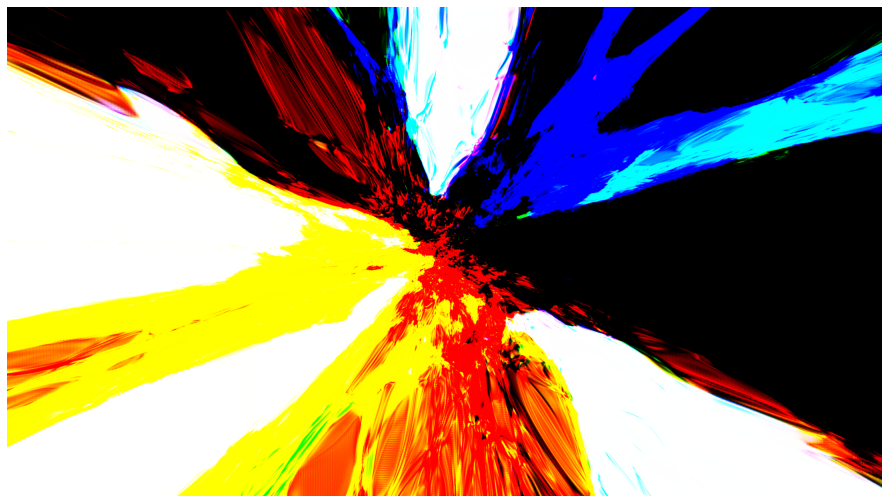

In [14]:
plt.subplots(figsize=(16, 9))
plt.imshow(to_viewable(produced.detach()))
plt.axis('off')

In [17]:
plt.imsave('fast.png', to_viewable(produced.detach()))

In [15]:
# # From: https://github.com/kkroening/ffmpeg-python/issues/246
# images = np.asarray(images) * 255
# images = np.maximum(images, 0)
# images = np.minimum(images, 255)

# def vidwrite(fn, images, framerate=60, vcodec='libx264'):
#     if not isinstance(images, np.ndarray):
#         images = np.asarray(images)
#     n,height,width,channels = images.shape
#     process = (
#         ffmpeg
#             .input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'.format(width, height))
#             .output(fn, pix_fmt='yuv420p', vcodec=vcodec, r=framerate)
#             .overwrite_output()
#             .run_async(pipe_stdin=True)
#     )
#     for frame in images:
#         process.stdin.write(
#             frame
#                 .astype(np.uint8)
#                 .tobytes()
#         )
#     process.stdin.close()
#     process.wait()
    
# vidwrite('training.mp4', images)

In [16]:
produced.max()

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)